In [25]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils.vis_utils import plot_model

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Constant

In [26]:
# Constants
TEST_DATA_DIR = 'data/test'
TRAIN_DATA_DIR = 'raw-data/train'
METADATA_PATH = 'raw-data/train.csv'

IMG_WIDTH = 32
IMG_HEIGTH = 32
BATCH_SIZE = 32
EPOCHS = 15

# Load augment & preprocess data

In [27]:
# Load labels
metadata = pd.read_csv(METADATA_PATH)
metadata.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [28]:
data = []

for index, row in metadata.iterrows():
    image = cv2.imread(f'{TRAIN_DATA_DIR}/{row.id}')
    label = 'has_cactus' if row.has_cactus else "no_cactus" 
    data.append({'image': image, 'label': label})

In [29]:
def augment(image):
    # Returns either a horizontal or vertically flipped image.
    return cv2.flip(image, np.random.randint(0, 1))

In [30]:
# Convert to numpy array in order to shuffle the data
np.random.shuffle(data)

# Split into train- and test sets
split = int(len(data) * 0.2)

train = data[split:]
test = data[:split]

# Randomly augment 30% of the train data
for item in train:
    if np.random.random() < 0.3:
        image = augment(item['image'])
        train.append({'image': image, 'label': item['label']})

In [31]:
# Split into lists of images and labels
X_train =  [x['image'] for x in train]
y_train = [x['label'] for x in train]

X_test = [x['image'] for x in test]
y_test = [x['label'] for x in test]

# Encode label
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

# Horizontally stack the array to get it into the correct shape
y_train = np.hstack((y_train, 1 - y_train))
y_test = np.hstack((y_test, 1 - y_test))

# Convert to numpy arrays for Keras
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Build model

In [32]:
# Build VGG model.
def add_vgg_block(model, n_filters, n_conv):
    # Add conv layers
    for _ in range(n_conv):
        model.add(Conv2D(n_filters, (3, 3), padding='same', activation='relu'))
    # Add max pooling layers
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    return model

In [33]:
input_layer = Input(shape=(IMG_HEIGTH, IMG_WIDTH, 3))

vgg_model = Sequential()
vgg_model.add(input_layer)
vgg_model = add_vgg_block(vgg_model, 64, 2)
vgg_model.add(Flatten())
vgg_model.add(Dense(2, activation='softmax'))
vgg_model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 32770     
Total params: 71,490
Trainable params: 71,490
Non-trainable params: 0
_________________________________________________________________


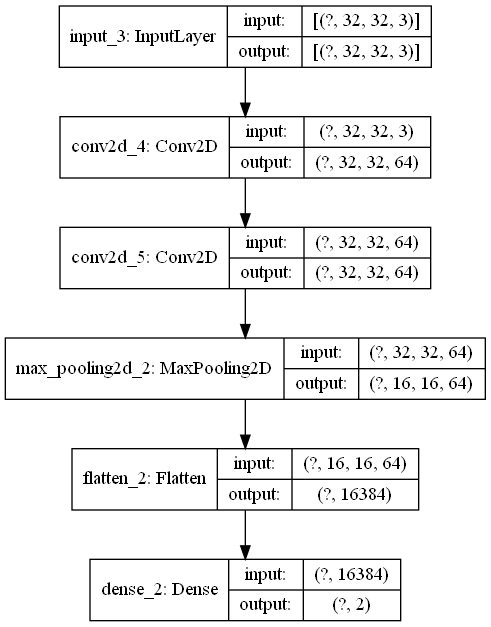

In [44]:
# Export model visualization
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

plot_model(vgg_model, to_file='vgg_model.png', show_shapes=True, show_layer_names=True)

In [35]:
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_history = vgg_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/15
626/626 [==============================] - 52s 83ms/step - loss: 0.8774 - accuracy: 0.8289
Epoch 2/15
626/626 [==============================] - 48s 76ms/step - loss: 0.2480 - accuracy: 0.8950
Epoch 3/15
626/626 [==============================] - 51s 81ms/step - loss: 0.1834 - accuracy: 0.9275
Epoch 4/15
626/626 [==============================] - 49s 79ms/step - loss: 0.1228 - accuracy: 0.9550
Epoch 5/15
626/626 [==============================] - 54s 87ms/step - loss: 0.0753 - accuracy: 0.9719
Epoch 6/15
626/626 [==============================] - 51s 82ms/step - loss: 0.0536 - accuracy: 0.9805
Epoch 7/15
626/626 [==============================] - 49s 79ms/step - loss: 0.0451 - accuracy: 0.9839
Epoch 8/15
626/626 [==============================] - 49s 78ms/step - loss: 0.0577 - accuracy: 0.9801
Epoch 9/15
626/626 [==============================] - 49s 77ms/step - loss: 0.0340 - accuracy: 0.9885
Epoch 10/15
626/626 [==============================] - 48s 77ms/step - loss: 0.034

# Evaluate

Text(0.5, 0, 'Epoch')

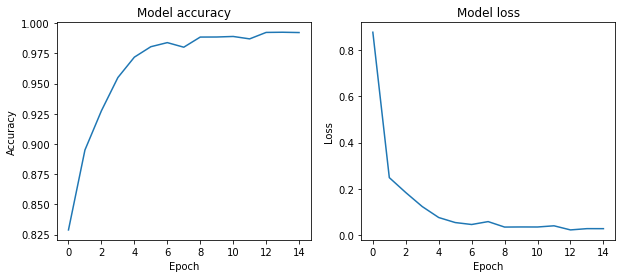

In [36]:
# Visualize model history
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(vgg_history.history['accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

axes[1].plot(vgg_history.history['loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

In [37]:
# Evaluate on test set
scores = vgg_model.predict(X_test)
predictions = np.argmax(scores, axis=1)

true = np.argmax(y_test, axis=1)

# inverse the encoding of the labels
predictions = encoder.inverse_transform(predictions)
true = encoder.inverse_transform(true)

In [38]:
labels = ['has_cactus', 'no_cactus']

df = pd.DataFrame(
    data=confusion_matrix(true, predictions, labels=labels),
    columns=labels,
    index=labels
)

df.head()

,has_cactus,no_cactus
has_cactus,841,54
no_cactus,18,2587


In [39]:
# Calculate True Negative (tn), False Positive (fp), False Negative (fn) and True Positive (tp) 
tn, fp, fn, tp = confusion_matrix(true, predictions).ravel()

table = pd.DataFrame({'type': ['True Negative', 'False Positive', 'False Negative', 'True Positive'], 'value': [tn, fp, fn, tp]})

table.head()

,type,value
0,True Negative,841
1,False Positive,54
2,False Negative,18
3,True Positive,2587


In [40]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = ((2 * recall) * precision) / (recall + precision)

print(f'Recall: {round(recall)}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Recall: 1.0
Precision: 0.9795531995456267
F1 Score: 0.986275257338925


In [41]:
# Show images where the prediction was wrong
fn_images = []
fp_images = []

for index, (predicted_label, true_label) in enumerate(zip(predictions, true)):
    if str(predicted_label) == 'no_cactus' and str(true_label) == 'has_cactus':
        fn_images.append(X_test[index])

# Get Indices of False Positives
for index, (predicted_label, true_label) in enumerate(zip(predictions, true)):
    if str(predicted_label) == 'has_cactus' and str(true_label) == 'no_cactus':
        fp_images.append(X_test[index])

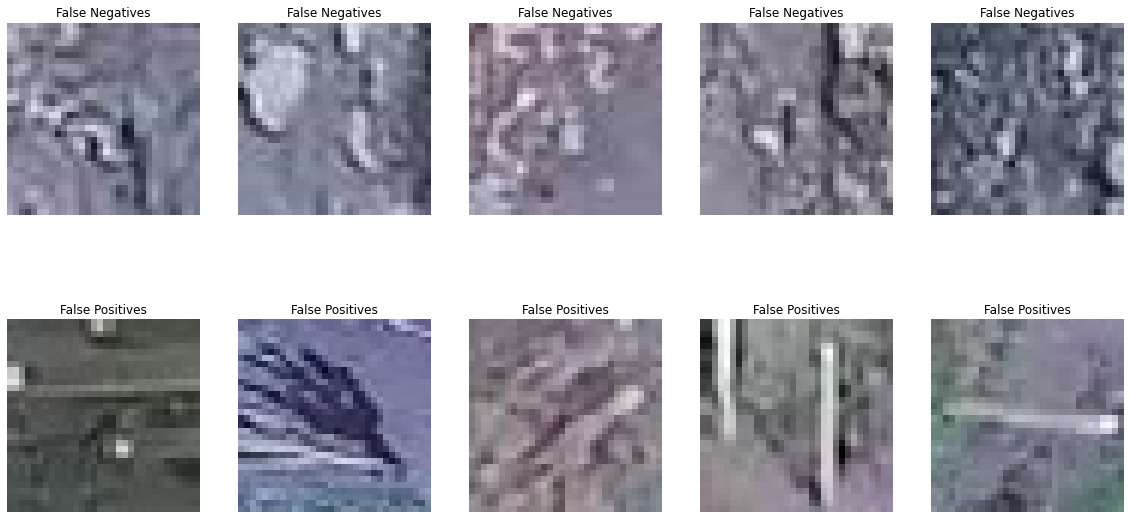

In [42]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
idx = np.random.randint(len(fn_images), size=5)

np.random.shuffle(fn_images)
np.random.shuffle(fp_images)

for index, img in enumerate(fn_images[:5]):
    axes[0, index].imshow(img)
    axes[0, index].axis('off')
    axes[0, index].set_title('False Negatives')

for index, img in enumerate(fp_images[:5]):
    axes[1, index].imshow(img)
    axes[1, index].axis('off')
    axes[1, index].set_title('False Positives')

# Export model

In [43]:
vgg_model.save('models/vgg')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/vgg\assets
